# 3R PCA

Based on paper there are 2 PCA on region 28.2MB to 29.2MB where values of Gmin are equal to zero and a random region where Gmin is equal to 1

In [140]:
%run imports.ipynb

/opt/conda/lib/python3.6/site-packages/distributed/dashboard/core.py:74: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [141]:
metadata = pd.read_csv("samples.meta.p1.txt", sep="\t")
metadata.head()

,index,ox_code,src_code,sra_sample_accession,population,country,region,contributor,contact,year,m_s,sex,n_sequences,mean_coverage,latitude,longitude
0,0,AB0085-C,BF2-4,ERS223996,BFS,Burkina Faso,Pala,Austin Burt,Sam O'Loughlin,2012,S,F,89905852,28.01,11.150,-4.235
1,1,AB0087-C,BF3-3,ERS224013,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,116706234,36.76,11.233,-4.472
2,2,AB0088-C,BF3-5,ERS223991,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,112090460,23.30,11.233,-4.472
3,3,AB0089-C,BF3-8,ERS224031,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,145350454,41.36,11.233,-4.472
4,4,AB0090-C,BF3-10,ERS223936,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,105012254,34.64,11.233,-4.472


In [142]:
geno = allel.GenotypeChunkedArray(callset_phase1["3R"]["calldata/GT"])
geno

<GenotypeChunkedArray shape=(13167162, 765, 2) dtype=int8 chunks=(524288, 51, 2)
   nbytes=18.8G cbytes=-1 cratio=-20145757860.0
   compression=blosc compression_opts={'cname': 'zstd', 'clevel': 1, 'shuffle': -1, 'blocksize': 0}
   values=zarr.core.Array>

In [143]:
pos_all = allel.SortedIndex(callset_phase1["3R"]["variants/POS"])

In [144]:
loc = pos_all.intersect_range(2820000, 2920000)
loc

0,1,2,3,4,...,33783,33784,33785,33786,33787
2820011,2820023,2820029,2820031,2820032,...,2919941,2919943,2919944,2919945,2919946


BFgam vs BFcol:

In [145]:
pop_selection = metadata.population.isin({'BFS', 'BFM'}).values

In [146]:
geno_subset = geno.subset(sel0=loc, sel1=pop_selection)
geno_subset

<GenotypeChunkedArray shape=(33788, 150, 2) dtype=int8 chunks=(2112, 150, 2)
   nbytes=9.7M cbytes=636.0K cratio=15.6
   compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
   values=zarr.core.Array>

In [147]:
ac = geno_subset.count_alleles()[:]
ac

<AlleleCountsArray shape=(33788, 4) dtype=int32>
284  16   0   0
298   2   0   0
300   0   0   0
...
300   0   0   0
300   0   0   0
294   6   0   0

In [148]:
loc_bi_seg = (ac.max_allele() <= 1) & (ac[:, :2].min(axis=1) > 7)
gf = geno_subset.compress(loc_bi_seg, axis=0)
gf

<GenotypeChunkedArray shape=(3020, 150, 2) dtype=int8 chunks=(755, 150, 2)
   nbytes=884.8K cbytes=276.0K cratio=3.2
   compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
   values=zarr.core.Array>

In [149]:
gn = geno_subset.to_n_alt()
gn

<ChunkedArrayWrapper shape=(33788, 150) dtype=int8 chunks=(2112, 150)
   nbytes=4.8M cbytes=473.6K cratio=10.5
   compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
   values=zarr.core.Array>

In [150]:
def ld_prune(gn, size, step, threshold=.1, n_iter=1):
    for i in range(n_iter):
        loc_unlinked = allel.locate_unlinked(gn, size=size, step=step, threshold=threshold)
        n = np.count_nonzero(loc_unlinked)
        n_remove = gn.shape[0] - n
        print('iteration', i+1, 'retaining', n, 'removing', n_remove, 'variants')
        gn = gn.compress(loc_unlinked, axis=0)
    return gn

In [151]:
gnu = ld_prune(gn, size=500, step=200, threshold=.1, n_iter=5)

iteration 1 retaining 20530 removing 13258 variants
iteration 2 retaining 18700 removing 1830 variants
iteration 3 retaining 18358 removing 342 variants
iteration 4 retaining 18179 removing 179 variants
iteration 5 retaining 18071 removing 108 variants


In [152]:
pop_colours = {
    'BFS': '#FF0000',
    'BFM': '#1E90FF',
}

In [153]:
populations = ['BFS', 'BFM']

In [154]:
population_subset = metadata[pop_selection]
population_subset.head()

,index,ox_code,src_code,sra_sample_accession,population,country,region,contributor,contact,year,m_s,sex,n_sequences,mean_coverage,latitude,longitude
0,0,AB0085-C,BF2-4,ERS223996,BFS,Burkina Faso,Pala,Austin Burt,Sam O'Loughlin,2012,S,F,89905852,28.01,11.150,-4.235
1,1,AB0087-C,BF3-3,ERS224013,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,116706234,36.76,11.233,-4.472
2,2,AB0088-C,BF3-5,ERS223991,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,112090460,23.30,11.233,-4.472
3,3,AB0089-C,BF3-8,ERS224031,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,145350454,41.36,11.233,-4.472
4,4,AB0090-C,BF3-10,ERS223936,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,105012254,34.64,11.233,-4.472


In [155]:
coords1, model1 = allel.pca(gnu, n_components=15, scaler='patterson')

/opt/conda/lib/python3.6/site-packages/allel/stats/preprocessing.py:138: RuntimeWarning: invalid value encountered in true_divide
  gn /= self.std_


ValueError: array must not contain infs or NaNs

In [17]:
def plot_pca_coords(coords, model, pc1, pc2, ax, sample_population):
    sns.despine(ax=ax, offset=5)
    x = coords[:, pc1]
    y = coords[:, pc2]
    for pop in populations:
        flt = (sample_population == pop)
        ax.plot(x[flt], y[flt], marker='o', linestyle=' ', mec=pop_colours[pop], mfc='none', mew=2.5, label=pop, markersize=1)
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model.explained_variance_ratio_[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model.explained_variance_ratio_[pc2]*100))
    

def fig_pca(coords, model, title, sample_population=None):
    if sample_population is None:
        sample_population = population_subset.population.values
    fig, ax = plt.subplots()
    y = model.explained_variance_
    x = np.arange(1, len(y)+1)
    ax.plot(x, y, 'ko')
    ax.set_xticks(x)
    ax.set_xlabel('principal component')
    ax.set_ylabel('variance explained')
    ax.grid(axis='x')
    # plot coords for PCs 1 vs 2, 3 vs 4
    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(2, 3, 1)
    plot_pca_coords(coords, model, 0, 1, ax, sample_population)
    ax = fig.add_subplot(2, 3, 2)
    plot_pca_coords(coords, model, 2, 3, ax, sample_population)
    ax = fig.add_subplot(2, 3, 3)
    plot_pca_coords(coords, model, 4, 5, ax, sample_population)
    ax = fig.add_subplot(2, 3, 4)
    plot_pca_coords(coords, model, 6, 7, ax, sample_population)
    ax = fig.add_subplot(2, 3, 5)
    plot_pca_coords(coords, model, 8, 9, ax, sample_population)
    ax = fig.add_subplot(2, 3, 6)
    plot_pca_coords(coords, model, 10, 11, ax, sample_population)
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
    fig.suptitle(title, y=1.02)
    fig.tight_layout()

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


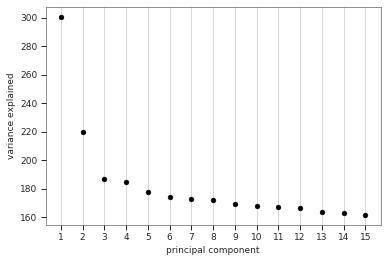

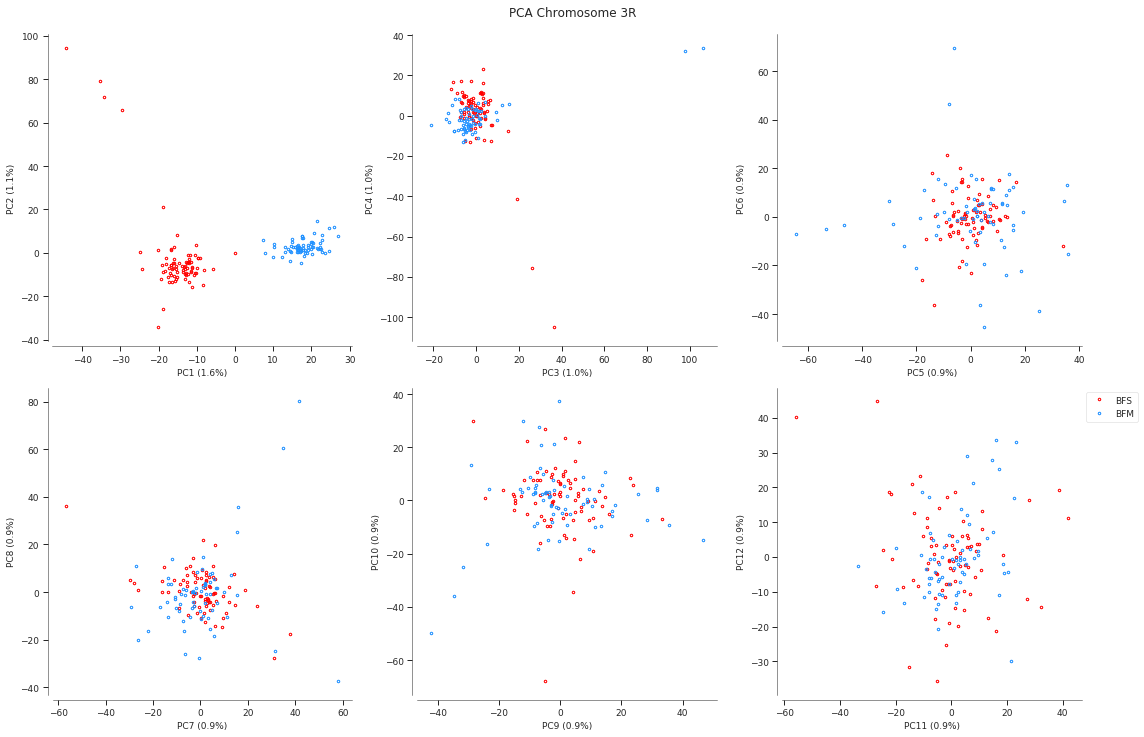

In [18]:
fig_pca(coords1, model1, 'PCA Chromosome 3R')

GHgam vs GHcol:

In [128]:
pop_selection = metadata.population.isin({'GHgam', 'GHcol'}).values

In [129]:
geno_subset = geno[pos_selection].subset(sel1=pop_selection)
geno_subset

<GenotypeArray shape=(56538, 67, 2) dtype=int8>
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
...
0/1 1/1 0/1 0/0 1/0 ... 0/1 0/0 1/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0

In [130]:
ac = geno_subset.count_alleles()[:]
ac

<AlleleCountsArray shape=(56538, 2) dtype=int32>
134   0
134   0
134   0
...
 85  49
134   0
133   1

In [131]:
flt = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 1)
gf = geno_subset.compress(flt, axis=0)
gf

<GenotypeArray shape=(7962, 67, 2) dtype=int8>
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 1/0
1/0 0/0 0/0 0/0 0/0 ... 1/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
...
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/1 1/1 0/1 0/0 1/0 ... 0/1 0/0 1/0 0/0 0/0

In [132]:
gn = gf.to_n_alt()
gn

array([[0, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 2, 1, ..., 1, 0, 0]], dtype=int8)

In [109]:
def ld_prune(gn, size, step, threshold=.1, n_iter=1):
    for i in range(n_iter):
        loc_unlinked = allel.locate_unlinked(gn, size=size, step=step, threshold=threshold)
        n = np.count_nonzero(loc_unlinked)
        n_remove = gn.shape[0] - n
        print('iteration', i+1, 'retaining', n, 'removing', n_remove, 'variants')
        gn = gn.compress(loc_unlinked, axis=0)
    return gn

In [110]:
gnu = ld_prune(gn, size=500, step=200, threshold=.1, n_iter=5)

iteration 1 retaining 922 removing 7040 variants
iteration 2 retaining 239 removing 683 variants
iteration 3 retaining 157 removing 82 variants
iteration 4 retaining 157 removing 0 variants
iteration 5 retaining 157 removing 0 variants


In [29]:
coords1, model1 = allel.pca(gn, n_components=10, scaler='patterson')

In [133]:
pop_colours = {
    'GHcol': '#FF0000',
    'GHgam': '#1E90FF',
}

In [134]:
populations = ['GHcol', 'GHgam']

In [135]:
population_subset = metadata[pop_selection]
population_subset.head()

,ox_code,src_code,population,country,location,site,contributor,contact,year,m_s,sex,n_sequences,mean_coverage,ebi_sample_acc,latitude,longitude
0,AA0040-C,Twifo_Praso__E2,GHcol,Ghana,Twifo Praso,Twifo Praso,David Weetman,David Weetman,2012,M,F,95033368,30.99,ERS311878,5.60858,-1.54926
1,AA0041-C,Twifo_Praso__H3,GHcol,Ghana,Twifo Praso,Twifo Praso,David Weetman,David Weetman,2012,M,F,95843804,31.70,ERS311886,5.60858,-1.54926
2,AA0042-C,Takoradi_C7,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,107420666,35.65,ERS311894,4.91217,-1.77397
3,AA0043-C,Takoradi_H8,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,95993752,29.46,ERS311902,4.91217,-1.77397
4,AA0044-C,Takoradi_D10,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,103044262,33.67,ERS311910,4.91217,-1.77397


In [139]:
population_subset.population.values

array(['GHcol', 'GHcol', 'GHcol', 'GHcol', 'GHcol', 'GHgam', 'GHcol',
       'GHgam', 'GHcol', 'GHcol', 'GHcol', 'GHcol', 'GHcol', 'GHcol',
       'GHgam', 'GHgam', 'GHcol', 'GHcol', 'GHcol', 'GHcol', 'GHcol',
       'GHgam', 'GHcol', 'GHcol', 'GHcol', 'GHcol', 'GHcol', 'GHcol',
       'GHgam', 'GHgam', 'GHgam', 'GHcol', 'GHcol', 'GHcol', 'GHcol',
       'GHcol', 'GHgam', 'GHcol', 'GHcol', 'GHcol', 'GHcol', 'GHcol',
       'GHcol', 'GHcol', 'GHcol', 'GHcol', 'GHgam', 'GHcol', 'GHcol',
       'GHcol', 'GHcol', 'GHcol', 'GHcol', 'GHcol', 'GHgam', 'GHcol',
       'GHcol', 'GHcol', 'GHcol', 'GHcol', 'GHgam', 'GHcol', 'GHcol',
       'GHcol', 'GHcol', 'GHcol', 'GHcol'], dtype=object)

In [137]:
def plot_pca_coords(coords, model, pc1, pc2, ax, sample_population):
    sns.despine(ax=ax, offset=5)
    x = coords[:, pc1]
    y = coords[:, pc2]
    for pop in populations:
        flt = (sample_population == pop)
        ax.plot(x[flt], y[flt], marker='o', linestyle=' ', mec=pop_colours[pop], mfc='none', mew=2.5, label=pop, markersize=1)
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model.explained_variance_ratio_[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model.explained_variance_ratio_[pc2]*100))
    

def fig_pca(coords, model, title, sample_population=None):
    if sample_population is None:
        sample_population = population_subset.population.values
    fig, ax = plt.subplots()
    y = model.explained_variance_
    x = np.arange(1, len(y)+1)
    ax.plot(x, y, 'ko')
    ax.set_xticks(x)
    ax.set_xlabel('principal component')
    ax.set_ylabel('variance explained')
    ax.grid(axis='x')
    # plot coords for PCs 1 vs 2, 3 vs 4
    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(2, 3, 1)
    plot_pca_coords(coords, model, 0, 1, ax, sample_population)
    ax = fig.add_subplot(2, 3, 2)
    plot_pca_coords(coords, model, 2, 3, ax, sample_population)
    ax = fig.add_subplot(2, 3, 3)
    plot_pca_coords(coords, model, 4, 5, ax, sample_population)
    ax = fig.add_subplot(2, 3, 4)
    plot_pca_coords(coords, model, 6, 7, ax, sample_population)
    ax = fig.add_subplot(2, 3, 5)
    plot_pca_coords(coords, model, 8, 9, ax, sample_population)
    ax = fig.add_subplot(2, 3, 6)
    plot_pca_coords(coords, model, 10, 11, ax, sample_population)
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
    fig.suptitle(title, y=1.02)
    fig.tight_layout()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 167 but corresponding boolean dimension is 67

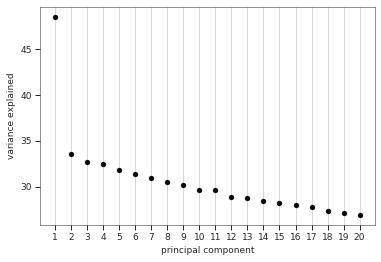

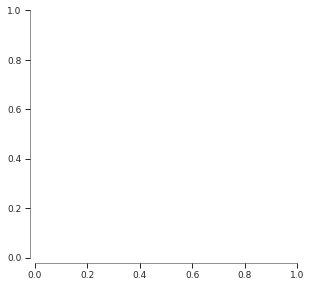

In [138]:
fig_pca(coords, model, 'PCA Chromosome 3R')

------------------------------------

In [156]:
metadata = pd.read_csv("samples.meta.p1.txt", sep="\t")
metadata.head()

,index,ox_code,src_code,sra_sample_accession,population,country,region,contributor,contact,year,m_s,sex,n_sequences,mean_coverage,latitude,longitude
0,0,AB0085-C,BF2-4,ERS223996,BFS,Burkina Faso,Pala,Austin Burt,Sam O'Loughlin,2012,S,F,89905852,28.01,11.150,-4.235
1,1,AB0087-C,BF3-3,ERS224013,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,116706234,36.76,11.233,-4.472
2,2,AB0088-C,BF3-5,ERS223991,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,112090460,23.30,11.233,-4.472
3,3,AB0089-C,BF3-8,ERS224031,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,145350454,41.36,11.233,-4.472
4,4,AB0090-C,BF3-10,ERS223936,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,105012254,34.64,11.233,-4.472


In [157]:
geno = allel.GenotypeChunkedArray(callset_phase1["3R"]["calldata/GT"])
geno

<GenotypeChunkedArray shape=(13167162, 765, 2) dtype=int8 chunks=(524288, 51, 2)
   nbytes=18.8G cbytes=-1 cratio=-20145757860.0
   compression=blosc compression_opts={'cname': 'zstd', 'clevel': 1, 'shuffle': -1, 'blocksize': 0}
   values=zarr.core.Array>

In [158]:
pop_selection = metadata.population.isin({'BFS', 'BFM'}).values

In [159]:
pos_all = allel.SortedIndex(callset_phase1["3R"]["variants/POS"])

In [160]:
loc = pos_all.intersect_range(2820000, 2920000)
loc

0,1,2,3,4,...,33783,33784,33785,33786,33787
2820011,2820023,2820029,2820031,2820032,...,2919941,2919943,2919944,2919945,2919946


In [ ]:
geno_subset = geno.subset(sel0 = loc, sel1=pop_selection)
geno_subset

In [ ]:
ac = geno_subset.count_alleles()[:]
ac

In [ ]:
flt = (ac.max_allele() <= 1) & (ac[:, :2].min(axis=1) > 7)

gf = geno_subset.compress(flt, axis=0)
gf

In [ ]:
gn = gf.to_n_alt()
gn

In [129]:
def ld_prune(gn, size, step, threshold=.1, n_iter=1):
    for i in range(n_iter):
        loc_unlinked = allel.locate_unlinked(gn, size=size, step=step, threshold=threshold)
        n = np.count_nonzero(loc_unlinked)
        n_remove = gn.shape[0] - n
        print('iteration', i+1, 'retaining', n, 'removing', n_remove, 'variants')
        gn = gn.compress(loc_unlinked, axis=0)
    return gn

In [130]:
gnu = ld_prune(gn, size=500, step=200, threshold=.1, n_iter=5)

iteration 1 retaining 2838 removing 5242 variants
iteration 2 retaining 2048 removing 790 variants
iteration 3 retaining 1819 removing 229 variants
iteration 4 retaining 1742 removing 77 variants
iteration 5 retaining 1708 removing 34 variants


In [131]:
coords1, model1 = allel.pca(gnu, n_components=10, scaler='patterson')

In [132]:
pop_colours = {
    'BFS': '#FF0000',
    'BFM': '#1E90FF',
}

In [133]:
populations = ['BFS', 'BFM']

In [134]:
population_subset = metadata[pop_selection]
population_subset.head()

,index,ox_code,src_code,sra_sample_accession,population,country,region,contributor,contact,year,m_s,sex,n_sequences,mean_coverage,latitude,longitude
0,0,AB0085-C,BF2-4,ERS223996,BFS,Burkina Faso,Pala,Austin Burt,Sam O'Loughlin,2012,S,F,89905852,28.01,11.150,-4.235
1,1,AB0087-C,BF3-3,ERS224013,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,116706234,36.76,11.233,-4.472
2,2,AB0088-C,BF3-5,ERS223991,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,112090460,23.30,11.233,-4.472
3,3,AB0089-C,BF3-8,ERS224031,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,145350454,41.36,11.233,-4.472
4,4,AB0090-C,BF3-10,ERS223936,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,105012254,34.64,11.233,-4.472


In [135]:
def plot_pca_coords(coords, model, pc1, pc2, ax, sample_population):
    sns.despine(ax=ax, offset=5)
    x = coords[:, pc1]
    y = coords[:, pc2]
    for pop in populations:
        flt = (sample_population == pop)
        ax.plot(x[flt], y[flt], marker='o', linestyle=' ', color=pop_colours[pop], 
                label=pop, markersize=6, mec='k', mew=.5)
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model.explained_variance_ratio_[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model.explained_variance_ratio_[pc2]*100))
    

def fig_pca(coords, model, title, sample_population=None):
    if sample_population is None:
        sample_population = population_subset.population.values
    # plot coords for PCs 1 vs 2, 3 vs 4
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 2, 1)
    plot_pca_coords(coords, model, 0, 1, ax, sample_population)
    ax = fig.add_subplot(1, 2, 2)
    plot_pca_coords(coords, model, 2, 3, ax, sample_population)
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
    fig.suptitle(title, y=1.02)
    fig.tight_layout()
    

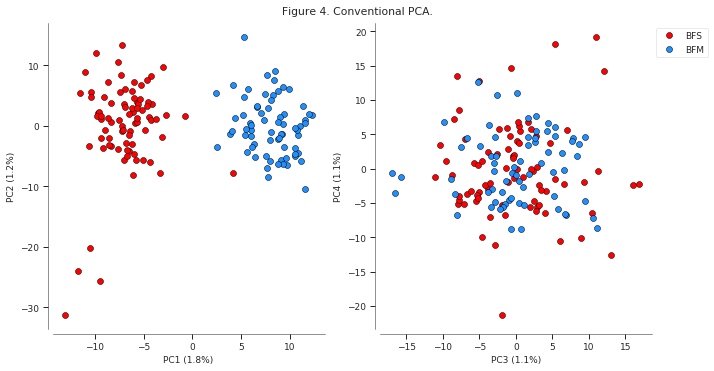

In [136]:
fig_pca(coords1, model1, 'Figure 4. Conventional PCA.')

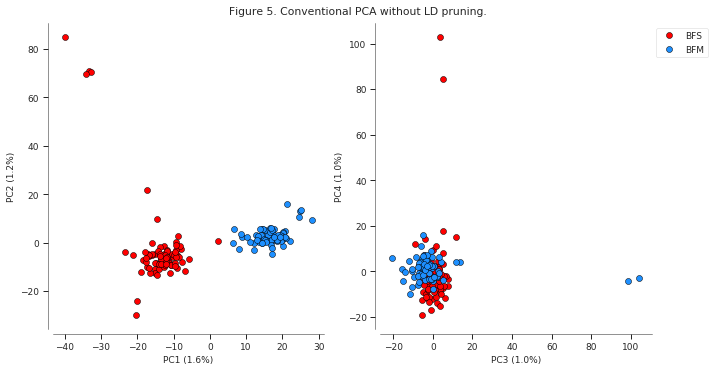

In [137]:
coords2, model2 = allel.pca(gn, n_components=10, scaler='patterson')
fig_pca(coords2, model2, 'Figure 5. Conventional PCA without LD pruning.')

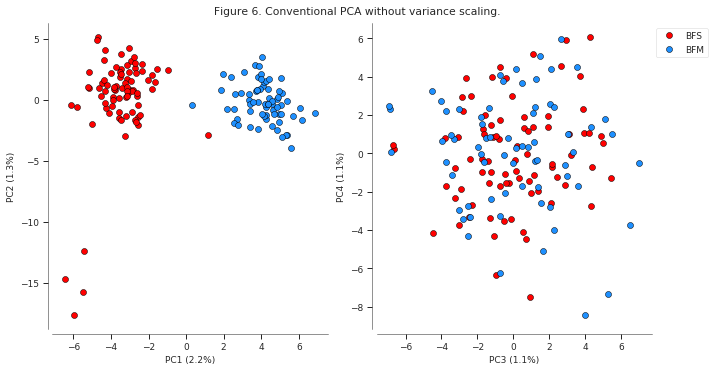

In [138]:
coords3, model3 = allel.pca(gn, n_components=10, scaler=None)
fig_pca(coords3, model3, 'Figure 6. Conventional PCA without variance scaling.')

-----------------------

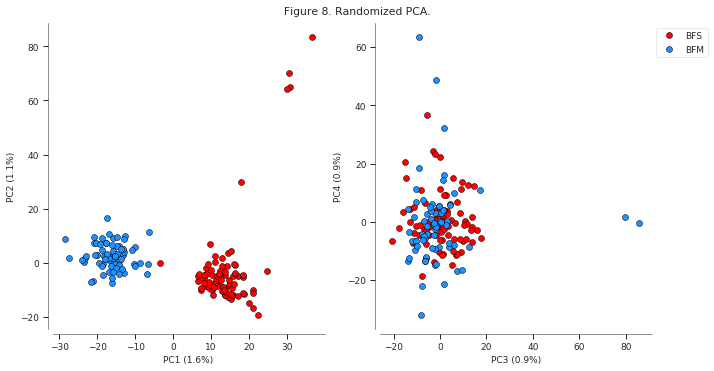

In [139]:
coords5, model5 = allel.randomized_pca(gn, n_components=10, scaler='patterson')
fig_pca(coords5, model5, 'Figure 8. Randomized PCA.')